In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler

from knn.my_knn import Knn, Metric, Window, Kernel


In [3]:
def my_accuracy_score(y_true: np.ndarray, y_pred: np.ndarray, alpha: int = 1) -> float:
    correct_predictions = np.sum(y_true == y_pred) * alpha
    total_predictions = len(y_true)
    accuracy = correct_predictions / total_predictions
    return accuracy


In [4]:
iris = load_iris()
df = pd.DataFrame(data=iris.data, columns=iris.feature_names)
df['target'] = iris.target
df

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,2
146,6.3,2.5,5.0,1.9,2
147,6.5,3.0,5.2,2.0,2
148,6.2,3.4,5.4,2.3,2


In [5]:
def get_split_data():
    data = load_iris()
    X, y = data.data, data.target
    scaler = StandardScaler()
    X_normalized = scaler.fit_transform(X)
    X_train, X_test, y_train, y_test = train_test_split(X_normalized, y, test_size=0.2, random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
    return X_test, X_train, X_val, y_test, y_train, y_val

In [6]:
def print_accuracy(y_pred, y_test):
    test_accuracy = my_accuracy_score(y_test, y_pred)
    print(f"Test Accuracy: {test_accuracy}")

In [7]:
def pretty_print_best(best_params, best_score):
    print(f"Best parameters: {best_params}")
    print(f"Best score: {best_score}")

In [8]:
def get_best_hyperparameters(X_train, X_val, y_train, y_val):
    knn = Knn()
    param_grid = {
        'k': [i for i in range(1, 11)],
        'kernel': [Kernel.EPANECHNIKOV, Kernel.UNIFORM, Kernel.GAUSSIAN],
        'window': [Window.FIXED, Window.NON_FIXED],
        'fixed_radius': [i for i in range(1, 5)],
        'metric': [Metric.COSINE, Metric.MINKOWSKI, Metric.CUSTOM_METRIC],
        'p': [i for i in range(1, 4)],
    }
    grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy', verbose=3)
    grid_search.fit(X_train, y_train)
    best_params = grid_search.best_params_
    best_score = grid_search.best_score_
    best_knn = grid_search.best_estimator_
    y_pred = best_knn.predict(X_val)
    print_accuracy(y_pred, y_val)
    return best_params, best_score

In [126]:
X_test, X_train, X_val, y_test, y_train, y_val = get_split_data()
best_params, best_score = get_best_hyperparameters(X_train, X_val, y_train, y_val)
print("~" * 40)
pretty_print_best(best_params, best_score)

Fitting 5 folds for each of 2160 candidates, totalling 10800 fits
[CV 1/5] END fixed_radius=1, k=1, kernel=<function epanechnikov_kernel at 0x15964b8b0>, metric=<function cosine_distance at 0x15964b280>, p=1, window=Window.FIXED;, score=0.800 total time=   0.2s
[CV 2/5] END fixed_radius=1, k=1, kernel=<function epanechnikov_kernel at 0x15964b8b0>, metric=<function cosine_distance at 0x15964b280>, p=1, window=Window.FIXED;, score=0.842 total time=   0.2s
[CV 3/5] END fixed_radius=1, k=1, kernel=<function epanechnikov_kernel at 0x15964b8b0>, metric=<function cosine_distance at 0x15964b280>, p=1, window=Window.FIXED;, score=0.842 total time=   0.3s
[CV 4/5] END fixed_radius=1, k=1, kernel=<function epanechnikov_kernel at 0x15964b8b0>, metric=<function cosine_distance at 0x15964b280>, p=1, window=Window.FIXED;, score=0.789 total time=   0.3s
[CV 5/5] END fixed_radius=1, k=1, kernel=<function epanechnikov_kernel at 0x15964b8b0>, metric=<function cosine_distance at 0x15964b280>, p=1, window=

/Users/hedwig_industries/Desktop/ML/lab1-knn-HedwigIndustries/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
3600 fits failed out of a total of 10800.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3600 fits failed with the following error:
Traceback (most recent call last):
  File "sklearn/metrics/_dist_metrics.pyx", line 2784, in sklearn.metrics._dist_metrics.PyFuncDistance64._dist
TypeError: only length-1 arrays can be converted to Python scalars

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/hedwig_industries/Desktop/ML/lab1-knn-HedwigIndustries/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation

In [172]:
def plot_accuracy_vs_k(X_test, X_train, y_test, y_train, kernel, window, fixed_radius, metric):
    ks = range(1, 30)
    train_accuracies = []
    test_accuracies = []

    for k in ks:
        knn = Knn(k=k, kernel=kernel, metric=metric, fixed_radius=fixed_radius, window=window)
        knn.fit(X_train, y_train)

        y_train_pred = knn.predict(X_train)
        train_accuracies.append(my_accuracy_score(y_train, y_train_pred))

        y_test_pred = knn.predict(X_test)
        test_accuracies.append(my_accuracy_score(y_test, y_test_pred))

    plt.plot(ks, train_accuracies, label='Train Accuracy')
    plt.plot(ks, test_accuracies, label='Test Accuracy')
    plt.xlabel('Number of Neighbors (k)')
    plt.ylabel('Accuracy')
    plt.title('Accuracy vs Number of Neighbors')
    plt.legend()
    plt.show()

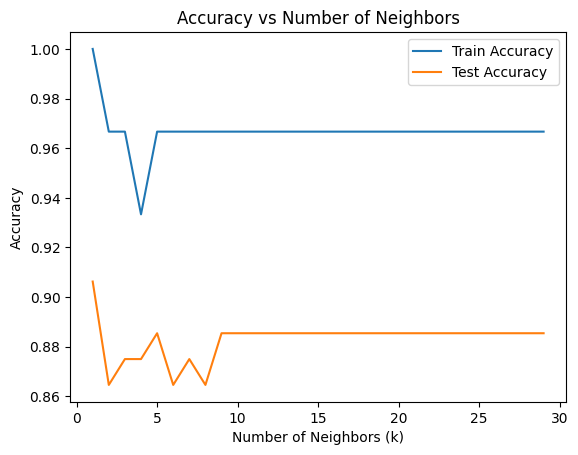

In [173]:
plot_accuracy_vs_k(X_train, X_test, y_train, y_test, kernel=Kernel.UNIFORM, window=Window.FIXED,
                   fixed_radius=1, metric=Metric.MINKOWSKI)

In [9]:
import numpy as np
from knn.my_knn import Kernel


def LOWESS(X, y, kernel=None):
    weights = []
    for i in range(len(X)):
        knn = Knn(k=9, fixed_radius=1, kernel=Kernel.UNIFORM, metric=Metric.COSINE, window=Window.NON_FIXED)
        knn.fit(np.delete(X, i, axis=0), np.delete(y, i, axis=0))
        new_y = (knn.predict(np.array([X[i]]))[0])
        if kernel is not None:
            weight = kernel(0 if y[i] == new_y else 1)
        else:
            weight = 0 if y[i] == new_y else 1
        weights.append(weight)

    return np.array(weights)

In [10]:
data = load_iris()
X, y = data.data, data.target
weights = LOWESS(X, y, kernel=Kernel.UNIFORM)
print(weights)
print(weights.shape)

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 1 0 1
 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1]
(150,)


In [22]:
from knn.my_knn import Metric, Kernel, Window

X_test, X_train, X_val, y_test, y_train, y_val = get_split_data()
knn = Knn(k=3, window=Window.NON_FIXED, fixed_radius=2, kernel=Kernel.CUSTOM_KERNEL, metric=Metric.CUSTOM_METRIC)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
print_accuracy(y_pred, y_test)

Test Accuracy: 0.9666666666666667


In [23]:
knn = Knn(k=3, window=Window.NON_FIXED, fixed_radius=2, kernel=Kernel.CUSTOM_KERNEL, metric=Metric.CUSTOM_METRIC, sample_weights=weights)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
print_accuracy(y_pred, y_test)

Test Accuracy: 0.9666666666666667
